# **#Tracking and Counting Vehicles**

## Libraries and Setup


In [1]:
!nvidia-smi

Thu Jul  3 21:05:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.53                 Driver Version: 537.53       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8               5W /  30W |    440MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)


c:\Users\Aditya Jain\OneDrive\finance summer\Model_implementation\CV-trackingObject


In [3]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.161  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Setup complete  (12 CPUs, 15.7 GB RAM, 391.5/475.7 GB disk)


In [4]:
import numpy as np
import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.25.1


##  Load Input Video


In [5]:
from supervision.assets import download_assets, VideoAssets

SOURCE_VIDEO_PATH = download_assets(VideoAssets.VEHICLES)

100%|██████████| 33.7M/33.7M [00:05<00:00, 6.73MB/s]


##  YOLOv8 Vehicle Detection


In [6]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")

In [7]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# the class names we have chosen
SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

# class ids matching the class names we have chosen
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [8]:
SELECTED_CLASS_IDS

[2, 3, 5, 7]

##  YOLOv8 Detection + Annotation on Sample Frame


In [9]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=1.5, text_color=sv.Color.BLACK)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]    #Gets result of first (and only) image

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)


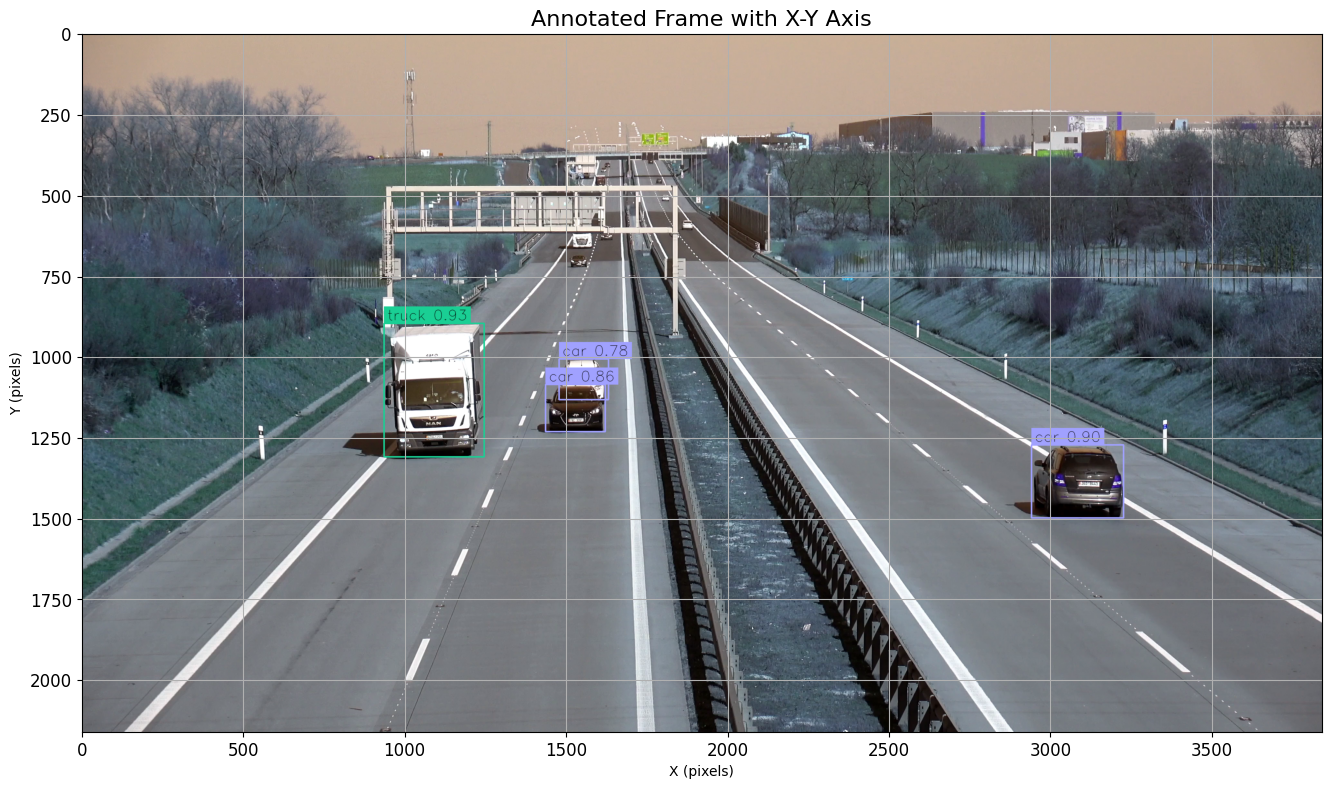

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(annotated_frame)
plt.title("Annotated Frame with X-Y Axis", fontsize=16)
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)  # You can set True if you want grid lines
plt.show()


##  Define Line Zone and Output Video Path

In [11]:
# settings
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [12]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

##  Vehicle Tracking, Line Counting, and Annotated Video Generation

In [13]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above (e.g., cars, trucks, not people).
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [  #Creates readable labels like: #3 car 0.87
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    # Step 6: Annotate Frame with Bounding Boxes, Traces, and Labels

    # Makes a copy of the original frame so we don't overwrite it.
    annotated_frame = frame.copy()

    #Draws trails (paths) showing the object's movement over time.
    '''
        Why Use Them Sequentially?
        Each call adds a visual layer:

        First the paths.

        Then the boxes over current positions.

        Then the text on top of those boxes.
    '''
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

##  Preview Output Frame

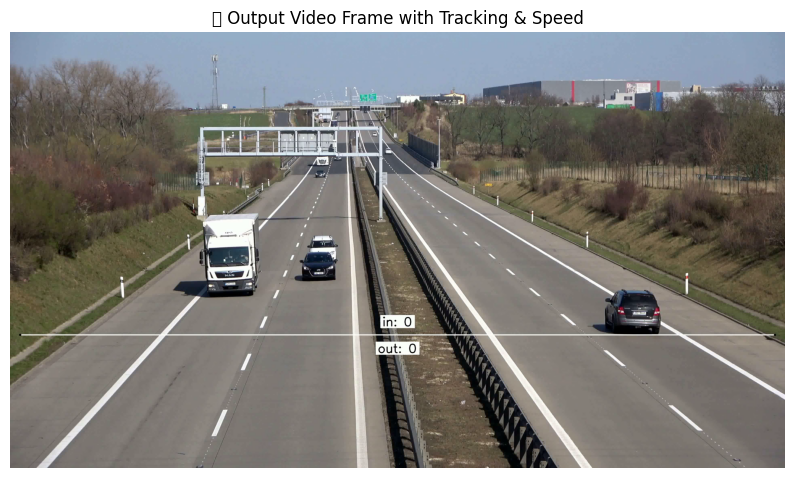

In [14]:
import cv2
from matplotlib import pyplot as plt

# Read a frame from the output video
cap = cv2.VideoCapture(r"C:\Users\Aditya Jain\OneDrive\finance summer\Model_implementation\CV-trackingObject\result.mp4")
ret, frame = cap.read()
cap.release()

# Show the frame using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("🚗 Output Video Frame with Tracking & Speed")
plt.show()


##  Summary

In this notebook, we successfully:

- Detected vehicles in traffic footage using **YOLOv8**
- Tracked vehicles using **ByteTrack**
- Estimated vehicle speeds using line crossing and frame timing
- Exported an annotated video showing all results

> 🔧 This project is a strong foundation for smart city applications like traffic monitoring, automated ticketing, and real-time analytics.
